<a href="https://colab.research.google.com/github/thisisindrajit/Athena/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

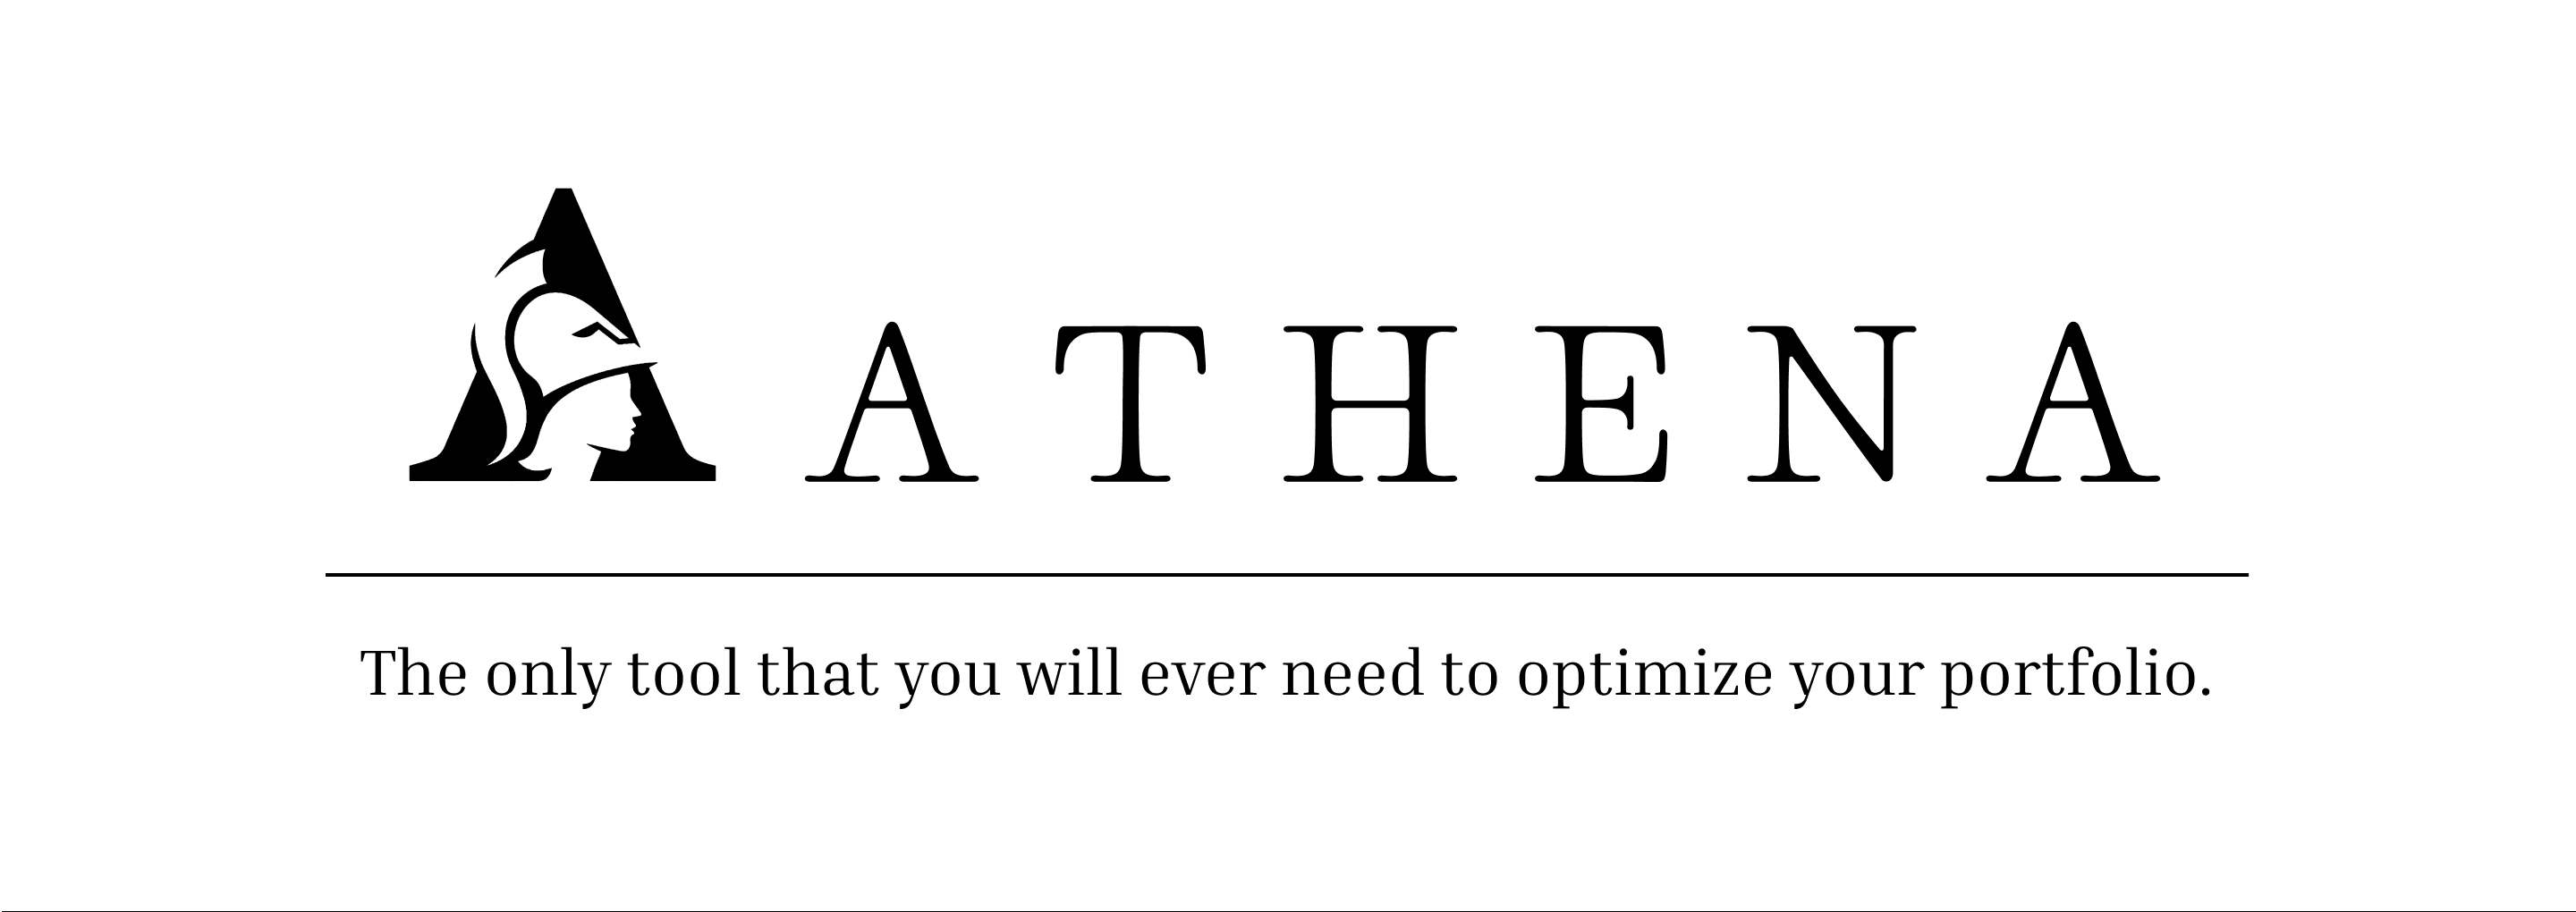

# Athena - Portfolio Optimization using DL and statistics

Athena uses a novel approach to portfolio optimization. It combines both deep learning and statistics along with asset fundamentals analysis to generate a robust portfolio consisting of value stocks with maximal returns and minimal risk, especially useful for long term investors. 

## Imports

In [1]:
!pip install yfinance
!pip install Riskfolio-Lib
!pip install ffn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import yfinance as yf
import math
import ffn
import riskfolio as rp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
import scipy
import pandas as pd
# from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

print("-----------------------------")
print(f'Tensorflow version: {tf.__version__}')
# print(f'Matplotlib version: {matplotlib.__version__}')
print("All neccessary imports done!")

-----------------------------
Tensorflow version: 2.8.0
All neccessary imports done!


## Variables

**Sample Portfolio 1 [Random selection]**

1. Asian Paints - ASIANPAINT.NS
1. Reliance - RELIANCE.NS
1. Pidilite Industries - PIDILITIND.NS
1. Lupin - LUPIN.NS
1. Indian Oil Corporation - IOC.NS

tickers = ["ASIANPAINT.NS", "RELIANCE.NS", "PIDILITIND.NS", "LUPIN.NS", "IOC.NS"]

---

**Sample Portfolio 2 [Selected based on popularity and market cap]**

1. Adani Ports - ADANIPORTS.NS
1. Asian Paints - ASIANPAINT.NS
1. Reliance - RELIANCE.NS
1. ICICI Bank - ICICIBANK.NS
1. Cipla - CIPLA.NS
1. Infosys -  INFY.NS
1. Lupin - LUPIN.NS
1. HDFC Bank - HDFCBANK.NS
1. TCS - TCS.NS
1. Airtel - BHARTIARTL.NS

tickers = ["ADANIPORTS.NS", "ASIANPAINT.NS", "RELIANCE.NS", "ICICIBANK.NS", "CIPLA.NS", "INFY.NS", "LUPIN.NS", "HDFCBANK.NS", "TCS.NS", "BHARTIARTL.NS"]

---

**Sample Portfolio 3 [Selected based on financial news sites suggestions without any fundamental analysis]** 

1. Coforge - COFORGE.NS
1. State bank of India - SBIN.NS
1. Blue star - BLUESTARCO.NS
1. Zen Technologies - ZENTEC.NS
1. Cummins India - CUMMINSIND.NS
1. Trent - TRENT.NS
1. Tata Power - TATAPOWER.NS
1. Vardhman Textiles - VTL.NS
1. Birlasoft - BSOFT.NS
1. APL Apollo Tubes - APLAPOLLO.NS
1. Dhampur Sugar Mills - DHAMPURSUG.NS

tickers = ["COFORGE.NS", "SBIN.NS", "BLUESTARCO.NS", "ZENTEC.NS", "CUMMINSIND.NS", "TRENT.NS", "TATAPOWER.NS", "VTL.NS", "BSOFT.NS", "APLAPOLLO.NS", "DHAMPURSUG.NS"]

---

**Sample Portfolio 4 [Value stocks selected based on fundamental analysis]**

1. Lincoln pharma - LINCOLN.NS
1. Aarti Drugs - AARTIDRUGS.NS
1. Glenmark Life Sciences - GLS.NS (Less data)
1. Thirumalai Chemicals Ltd - TIRUMALCHM.NS
1. S P Apparels Ltd - SPAL.NS 
1. ICICI securities - ISEC.NS
1. Shyam Metallics - SHYAMMETL.NS (Less data)
1. GTPL Hathway - GTPL.NS
1. Birlasoft - BSOFT.NS

tickers = ["LINCOLN.NS", "AARTIDRUGS.NS", "GLS.NS", "TIRUMALCHM.NS", "SPAL.NS", "ISEC.NS", "SHYAMMETL.NS", "GTPL.NS", "BSOFT.NS"]

---

**Sample Portfolio 5 [Combination of sample portfolio 4 and 5]**

1. Coforge - COFORGE.NS
1. State bank of India - SBIN.NS
1. Tata Power - TATAPOWER.NS
1. Birlasoft - BSOFT.NS
1. APL Apollo Tubes - APLAPOLLO.NS
1. Dhampur Sugar Mills - DHAMPURSUG.NS
1. Lincoln pharma - LINCOLN.NS
1. Aarti Drugs - AARTIDRUGS.NS
1. Thirumalai Chemicals Ltd - TIRUMALCHM.NS
1. ICICI securities - ISEC.NS


tickers = ["COFORGE.NS", "SBIN.NS", "TATAPOWER.NS", "BSOFT.NS", "APLAPOLLO.NS", "DHAMPURSUG.NS", "LINCOLN.NS", "AARTIDRUGS.NS", "TIRUMALCHM.NS", "ISEC.NS"]

In [3]:
tickers = ["COFORGE.NS", "SBIN.NS", "TATAPOWER.NS", 
           "BSOFT.NS", "APLAPOLLO.NS", "DHAMPURSUG.NS", "LINCOLN.NS", "AARTIDRUGS.NS", "TIRUMALCHM.NS", "ISEC.NS"]
# tickers = ["ADANIPORTS.NS", "ASIANPAINT.NS", "RELIANCE.NS", "ICICIBANK.NS", "CIPLA.NS", 
#            "INFY.NS", "LUPIN.NS", "HDFCBANK.NS", "TCS.NS", "BHARTIARTL.NS"]  
               
# sorting tickers
tickers.sort()
min_prev_days = 252
port_len = len(tickers) # length of portfolio
max_port_len = 15 # maximum length of portfolio that is allowed

## Getting data from API (YFinance)

Reference - https://pypi.org/project/yfinance/

In [4]:
def get_data(tickers, period="5y"):

  if port_len > max_port_len:
    print(f'Only {max_port_len} number of assets allowed in portfolio!')
    return None
  
  # download data of ticker symbols
  data = yf.download(tickers, period=period)
  
  # check whether if any ticker symbol has less than min_prev_days days of data
  for i in range(port_len):
    cur_ticker_count = data.iloc[:, i].count()
    print(f'No of rows available for {tickers[i]} is {cur_ticker_count}')

    if cur_ticker_count < min_prev_days:
      print(f'{tickers[i]} has less than {min_prev_days} days of historical price data. Please consider removing the asset or adding some other asset.')
      return None
    
  # remove open, high, low, volume, adj close columns
  data = data.drop("Open", axis = 1)
  data = data.drop("High", axis = 1)
  data = data.drop("Low", axis = 1)
  data = data.drop("Volume", axis = 1)
  data = data.drop("Adj Close", axis = 1)

  return data

In [5]:
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max

df = get_data(tickers, period="5y")
extra_info_tickers = yf.Tickers(tickers)

[*********************100%***********************]  10 of 10 completed
No of rows available for AARTIDRUGS.NS is 1236
No of rows available for APLAPOLLO.NS is 1236
No of rows available for BSOFT.NS is 1236
No of rows available for COFORGE.NS is 1236
No of rows available for DHAMPURSUG.NS is 1236
No of rows available for ISEC.NS is 1025
No of rows available for LINCOLN.NS is 1236
No of rows available for SBIN.NS is 1236
No of rows available for TATAPOWER.NS is 1236
No of rows available for TIRUMALCHM.NS is 1236


In [6]:
df = df.dropna()
df = df["Close"]
df

,AARTIDRUGS.NS,APLAPOLLO.NS,BSOFT.NS,COFORGE.NS,DHAMPURSUG.NS,ISEC.NS,LINCOLN.NS,SBIN.NS,TATAPOWER.NS,TIRUMALCHM.NS
Date,,,,,,,,,,
2018-04-04,135.949997,204.565002,136.168472,866.299988,136.100006,445.100006,225.649994,247.300003,83.050003,189.070007
2018-04-05,140.774994,211.684998,137.442810,879.849976,136.600006,445.399994,227.000000,259.299988,83.500000,192.725006
2018-04-06,146.225006,210.524994,139.742859,903.500000,137.149994,441.299988,226.550003,259.700012,84.500000,193.789993
2018-04-09,149.087494,212.089996,138.468506,883.450012,136.850006,436.149994,231.600006,260.649994,85.000000,198.755005
2018-04-10,145.524994,216.360001,137.318497,885.849976,141.000000,427.649994,230.300003,263.299988,87.099998,197.994995
...,...,...,...,...,...,...,...,...,...,...
2022-05-23,425.350006,883.799988,378.100006,3853.199951,265.500000,464.250000,284.649994,460.899994,229.800003,245.850006
2022-05-24,418.899994,907.500000,373.700012,3714.050049,252.250000,440.750000,279.250000,462.049988,227.000000,240.699997
2022-05-25,406.549988,878.750000,343.250000,3453.949951,239.649994,428.399994,264.200012,454.100006,220.899994,226.000000


## Converting company information to DataFrame 

In [7]:
# Information of the company of first ticker symbol
infodf0 = pd.DataFrame.from_dict(extra_info_tickers.tickers[tickers[0]].info,orient='index')
infodf0 = infodf0.reset_index()
infodf0

,index,0
0,zip,400 022
1,sector,Healthcare
2,longBusinessSummary,"Aarti Drugs Limited, through its subsidiaries,..."
3,city,Mumbai
4,phone,91 22 2401 9025
...,...,...
147,bidSize,0
148,dayHigh,420.85
149,regularMarketPrice,412.65
150,preMarketPrice,None


## Visualizing the data

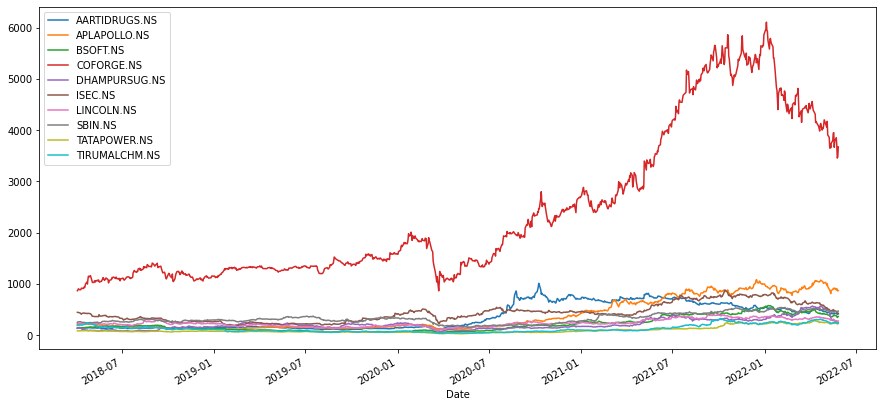

In [8]:
# Pandas has inbuilt support for matplotlib, so we can use plot function directly

df.plot(label = tickers, figsize = (15,7))
plt.show()

## Geting information like balance sheet, cashflow etc. from YFinance API

### Balance sheet

In [9]:
extra_info_tickers.tickers[tickers[4]].balance_sheet

,2021-03-31,2020-03-31,2019-03-31,2018-03-31
Intangible Assets,2.480000e+07,2.870000e+07,3.250000e+07,3.280000e+07
Capital Surplus,3.799400e+09,3.799400e+09,3.799400e+09,3.799400e+09
Total Liab,1.910750e+10,2.507240e+10,2.700800e+10,2.133180e+10
Total Stockholder Equity,1.560060e+10,1.361670e+10,1.224700e+10,1.001300e+10
Other Current Liab,4.403000e+08,6.482000e+08,7.759000e+08,4.107000e+08
Total Assets,3.470810e+10,3.869140e+10,3.926620e+10,3.135720e+10
Common Stock,6.638000e+08,6.638000e+08,6.638000e+08,6.638000e+08
Other Current Assets,3.692000e+08,4.728000e+08,3.875000e+08,4.029000e+08
Retained Earnings,1.101130e+10,9.117700e+09,7.673100e+09,5.408200e+09
Other Liab,7.570000e+08,4.902000e+08,9.209000e+08,7.029000e+08


### Cashflow

In [10]:
extra_info_tickers.tickers[tickers[3]].cashflow

,2022-03-31,2021-03-31,2020-03-31,2019-03-31
Investments,4.500000e+08,2.100000e+07,3.702000e+09,-4.300000e+07
Change To Liabilities,2.153000e+09,7.850000e+08,9.580000e+08,3.100000e+08
Total Cashflows From Investing Activities,-9.564000e+09,-2.354000e+09,1.123000e+09,-2.300000e+09
Net Borrowings,3.133000e+09,-6.180000e+08,-4.800000e+07,-5.400000e+07
Total Cash From Financing Activities,-1.558000e+09,-5.531000e+09,-1.327000e+09,-1.063000e+09
Change To Operating Activities,-4.340000e+08,4.080000e+08,-1.551000e+09,-7.810000e+08
Issuance Of Stock,5.100000e+07,1.800000e+07,2.860000e+08,8.700000e+07
Net Income,6.617000e+09,4.556000e+09,4.440000e+09,4.033000e+09
Change In Cash,-3.531000e+09,-1.960000e+08,3.001000e+09,1.092000e+09
Effect Of Exchange Rate,-6.500000e+07,6.600000e+07,1.130000e+08,-7.200000e+07


### Financials

In [11]:
extra_info_tickers.tickers[tickers[6]].financials

,2022-03-31,2021-03-31,2020-03-31,2019-03-31
Research Development,None,None,None,None
Effect Of Accounting Charges,None,None,None,None
Income Before Tax,959395000.0,837205000.0,672326000.0,621946000.0
Minority Interest,NaN,4076000.0,3820000.0,3552000.0
Net Income,693552000.0,622236000.0,514394000.0,487101000.0
Selling General Administrative,704689000.0,756637000.0,734981000.0,660064000.0
Gross Profit,2535417000.0,2232811000.0,2003579000.0,1863190000.0
Ebit,873930000.0,798008000.0,583389000.0,608204000.0
Operating Income,873930000.0,798008000.0,583389000.0,608204000.0
Other Operating Expenses,875919000.0,602563000.0,591198000.0,521390000.0


# Helper functions

## Calculate expected returns, annual volatility and Sharpe ratio of optimized portfolio

In [12]:
def get_port_stats(returns, weights, cov_matrix):
  # EXPECTED ANNUAL RETURN (252 is the approx number of trading days in a year)
  annual_returns = returns.mean() * 252
  # find expected portfolio returns
  expected_return = np.sum(weights.T.values * annual_returns.values)

  # ANNUAL VOLATILITY
  # find annual volatility of portfolio
  volatility = np.sqrt(np.dot(weights.T,np.dot(cov_matrix * 252,weights)))

  # SHARPE RATIO (Assuming 0 risk free return. Alternative is to use a value of 0.02)
  sharpe_ratio = expected_return / volatility

  print(f"Expected Returns: {(expected_return * 100).round(decimals = 2)}%")
  print(f"Annual Volatility: {(volatility * 100).round(decimals = 2)[0][0]}%")
  print(f"Sharpe Ratio: {sharpe_ratio.round(decimals = 2)[0][0]}")

  return (expected_return * 100).round(decimals = 2), (volatility * 100).round(decimals = 2)[0][0], sharpe_ratio.round(decimals = 2)[0][0]

## Softmax function

In [13]:
def softmax(x):
  """Compute softmax values for each sets of scores in x."""
  return np.exp(x) / np.sum(np.exp(x), axis=0)

# Calculating Piotroski F-Score

The Piotroski Score is calculated based on nine criteria that can be grouped into three different categories:
1. **Category 1: Profitability**
> - Net Income > 0 (Score +1)
> - Return on Assets (ROA) > 0 (Score +1)
> - Cash flow from operating activities (CFO) > 0 (Score +1)
> - CFO > Net Income (Score +1)
1. **Category 2: Leverage, Liquidity, and Source of Funds**
> - Long Term Debt [Current Year] < Long Term Debt [Previous Year] (Score +1)
> - Current Ratio [Current Year] > Current Ratio [Previous Year] (Score +1)
> - No new shares issued in the last year (Score +1)
1. **Category 3: Operating Efficiency**
> - Gross Margin [Current Year] > Gross Margin [Previous Year] (Score +1)
> - Asset Turnover Ratio [Current Year] > Asset Turnover Ratio [Previous Year] (Score +1)
---
With each criterion met, a score of 1 will be merited. 

```
Good or high score = 7, 8, 9
Bad or low score = 0, 1, 2, 3
```

Reference - https://www.investopedia.com/terms/p/piotroski-score.asp



## Helper functions for calculating Piotroski Score

In [14]:
# Getting the net income of an asset
def get_net_income(income_df):
  return float(income_df.loc['Net Income'][0])

# Get return on assets
"""The term return on assets (ROA) refers to a financial ratio that indicates how profitable 
a company is in relation to its total assets. Corporate management, analysts, and investors 
can use ROA to determine how efficiently a company uses its assets to generate a profit."""
def get_roa(balance_df, income_df):
  current = float(balance_df.loc['Total Assets'][0])
  previous = float(balance_df.loc['Total Assets'][1])

  av_assets=(current+previous)/2

  return get_net_income(income_df)/av_assets

# Get operating cash flow
def get_ocf(cash_df):
  return float(cash_df.loc['Total Cash From Operating Activities'][0])

# Get long term debt
def get_ltdebt(balance_df):
  if 'Long Term Debt' in balance_df.index:
    current = float(balance_df.loc['Long Term Debt'][0])
    previous = float(balance_df.loc['Long Term Debt'][1])

    return previous-current

  return None

# Get current ratio
def get_current_ratio(balance_df):
  current_TCA = float(balance_df.loc['Total Current Assets'][0])
  previous_TCA = float(balance_df.loc['Total Current Assets'][1])
  current_TCL = float(balance_df.loc['Total Current Liabilities'][0])
  previous_TCL = float(balance_df.loc['Total Current Liabilities'][1])
  
  ratio1 = current_TCA/current_TCL
  ratio2 = previous_TCA/previous_TCL
  
  return ratio1-ratio2

# Get count of new shares if issued
def get_new_shares(balance_df):
  current = float(balance_df.loc['Common Stock'][0])
  previous = float(balance_df.loc['Common Stock'][1])
  
  return current-previous

# Get gross margin
def get_gross_margin(income_df):
  current = float(income_df.loc['Gross Profit'][0])/float(income_df.loc['Total Revenue'][0])
  previous = float(income_df.loc['Gross Profit'][1])/float(income_df.loc['Total Revenue'][1])

  return current-previous


# Get asset turnover ratio
def get_asset_turnover_ratio(income_df, balance_df):
  current = float(balance_df.loc['Total Assets'][0])
  prev_1 = float(balance_df.loc['Total Assets'][1])
  prev_2 = float(balance_df.loc['Total Assets'][2])
  
  av_assets1 = (current+prev_1)/2
  av_assets2 = (prev_1+prev_2)/2
  
  atr1 = float(income_df.loc['Total Revenue'][0])/av_assets1
  atr2 = float(income_df.loc['Total Revenue'][1])/av_assets2

  return atr1-atr2

In [15]:
def get_piotroski_score(income_df, balance_df, cash_df):
  score=0
  passed = []

  print(f"Net income - {get_net_income(income_df)}")
  
  if get_net_income(income_df)>0:
    passed.append("Net income")
    score+=1

  print(f'ROA - {get_roa(balance_df, income_df)}')
  
  if get_roa(balance_df, income_df)>0:
    passed.append("ROA")
    score+=1

  print(f"Operating Cash flow - {get_ocf(cash_df)}")
     
  if get_ocf(cash_df)>0:
    passed.append("CFO")
    score+=1

  print(f"Operating Cash flow > Net Income - {get_ocf(cash_df)>get_net_income(income_df)}")
      
  if get_ocf(cash_df)>get_net_income(income_df):
    passed.append("CFO > NI")
    score+=1

  print(f"Long term debt - {get_ltdebt(balance_df)}")

  if get_ltdebt(balance_df) is None:
    print("No data on long term debt!")

  elif get_ltdebt(balance_df)>0:
    passed.append("LTD")
    score+=1
  
  print(f"Current ratio - {get_current_ratio(balance_df)}")
      
  if get_current_ratio(balance_df)>0:
    passed.append("CR")
    score+=1

  print(f"New shares count - {get_new_shares(balance_df)}")
      
  if get_new_shares(balance_df)>0:
    passed.append("New shares")
    score+=1

  print(f"New shares count - {get_gross_margin(income_df)}")
      
  if get_gross_margin(income_df)>0:
    passed.append("GM")
    score+=1

  print((f"Asset turnover ratio - {get_asset_turnover_ratio(income_df, balance_df)}"))
      
  if get_asset_turnover_ratio(income_df, balance_df)>0:
    passed.append("ATR")
    score+=1

  print(f'Passed metrics - {passed}')
      
  return score

# Calculating RoE (Return on Equity)

The Return on equity is a measure of the profitability of a business in relation to the equity. 

Because stock holders' equity is equal to a company's assets minus its debt, RoE is considered the return on net assets. RoE is considered a gauge of a corporation's profitability and how efficient it is in generating profits.

Negative RoE -  When a company incurs a loss, there is no net income and so the return on equity is negative. 

Reference - https://towardsdatascience.com/calculating-return-on-equity-with-python-1ea583cd53bd

In [16]:
def get_roe(income_df, balance_df):
  ni = float(income_df.loc['Net Income'][0])

  eq1 = float(balance_df.loc["Total Stockholder Equity"][0])
  eq2 = float(balance_df.loc["Total Stockholder Equity"][1])

  avg_eq = (eq1+eq2)/2
  roe = ni/avg_eq

  return roe

# Calculating RoCE (Return on Capital Employed)

RoCE can be especially useful when comparing the performance of companies in capital-intensive sectors, such as utilities and telecoms. This is because, unlike other fundamentals such as return on equity (RoE), which only analyzes profitability related to a company’s shareholders’ equity, RoCE considers debt and equity. This can help neutralize financial performance analysis for companies with significant debt.

Ultimately, the calculation of RoCE tells you the amount of profit a company is generating per \$1 of capital employed. The more profit per \$1 a company can generate, the better. Thus, a higher RoCE indicates stronger profitability across company comparisons.

Reference - https://www.investopedia.com/terms/r/roce.asp

In [17]:
def get_roce(income_df,balance_df):
  # n = float(income_df.loc["Ebit"][0])
  n = float(income_df.loc["Operating Income"][0])
  d = float(balance_df.loc["Total Assets"][0])-float(balance_df.loc["Total Current Liabilities"][0])

  roce = n/d;

  return roce

# Calculating P/E Ratio


The price-to-earnings (P/E) ratio relates a company's share price to its earnings per share.

A high P/E ratio could mean that a company's stock is overvalued, or else that investors are expecting high growth rates in the future.

Companies that have no earnings or that are losing money do not have a P/E ratio because there is nothing to put in the denominator.

As far as Nifty is concerned, it has traded in a PE range of 10 to 30 historically. Average PE of Nifty in the last 20 years was around 20. So **PEs below 20 may provide good investment opportunities; lower the PE below 20, more attractive the investment potential.**

Reference - https://www.miraeassetmf.co.in/knowledge-center/what-is-pe-ratio

In [18]:
def get_pe(info):
  pe = float(info["currentPrice"]) / float(info["trailingEps"])
  
  return pe

# Calculating Debt-to-Asset Ratio

Debt-to-Asset Ratio is total debt divided by total assets.

The debt to asset ratio is commonly used by analysts, investors, and creditors to determine the overall risk of a company. Companies with a higher ratio are more leveraged and, hence, riskier to invest in and provide loans to. If the ratio steadily increases, it could indicate a default at some point in the future.

- A ratio equal to one (=1) means that the company owns the same amount of liabilities as its assets. It indicates that the company is highly leveraged.
- A ratio greater than one (>1) means the company owns more liabilities than it does assets. It indicates that the company is extremely leveraged and highly risky to invest in or lend to.
- A ratio of less than one (<1) means the company owns more assets than liabilities and can meet its obligations by selling its assets if needed. The lower the debt to asset ratio, the less risky the company.

In [19]:
def get_debt_to_assets_ratio(balance_df, info):
  if info["totalDebt"]:
    da = float(info["totalDebt"]) / float(balance_df.loc["Total Assets"][0])
    return da

  elif 'Short Long Term Debt' in balance_df.index:
    da = float(balance_df.loc["Short Long Term Debt"][0]) / float(balance_df.loc["Total Assets"][0])
    return da

  elif 'Long Term Debt' in balance_df.index:
    da = float(balance_df.loc["Long Term Debt"][0]) / float(balance_df.loc["Total Assets"][0])
    return da

  return 0

# Calculating CAGR (Compound Annual Growth Rate)

The compound annual growth rate (CAGR) is the rate of return (RoR) that would be required for an investment to grow from its beginning balance to its ending balance, assuming the profits were reinvested at the end of each period of the investment's life span.

In [20]:
def get_cagr(ticker):
  return round(ffn.core.calc_cagr(df[ticker]) * 100, 2)

# Checking if current assets are 1.5 times the current liabilities


In [21]:
def assets_vs_liabilities(balance_df):
  if balance_df.loc["Total Current Assets"][0] > (balance_df.loc["Total Current Liabilities"][0] * 1.5):
    return True

  return False

# Fundamentals analyser

In [22]:
def calc_piotroski_score(ticker, income_df, balance_df, cash_df):

  ps = get_piotroski_score(income_df, balance_df, cash_df)
  print(f'Piotroski score for {ticker} is {ps}')

  return int(ps)

In [23]:
def calc_roe(ticker, income_df, balance_df):
  roe = get_roe(income_df, balance_df)
  print(f'RoE for {ticker} is {round(roe * 100, 2)}%')

  return round(roe * 100, 2)

In [24]:
def calc_roce(ticker, income_df, balance_df):
  roce = get_roce(income_df, balance_df)
  print(f'RoCE for {ticker} is {round(roce * 100, 2)}%')

  return round(roce * 100, 2)

In [25]:
def calc_pe(ticker, info):
  pe = get_pe(info)
  print(f'P/E ratio for {ticker} is {round(pe, 2)}')

  return round(pe, 2)

In [26]:
def calc_debt_to_assets_ratio(ticker, balance_df, info):
  da = get_debt_to_assets_ratio(balance_df, info)
  print(f'Debt to asset ratio for {ticker} is {round(da, 2)}')

  return round(da, 2)

In [27]:
def calc_cagr(ticker):
  cagr = get_cagr(ticker)
  print(f'CAGR for {ticker} is {cagr}%')

  return cagr

In [28]:
def check_if_assets_are_greater_than_liabilities(ticker, balance_df):
  is_greater = assets_vs_liabilities(balance_df)

  if is_greater is True:
    print(f'Current assets of {ticker} are 1.5 times it\'s current liabilities. - GOOD ASSET!')
    return "Yes"
  else:
    print(f'Current assets of {ticker} aren\'t 1.5 times it\'s current liabilities. - NOT SO GOOD ASSET!')
    return "No"

In [29]:
fundamentals_analyser_dict = dict()

In [30]:
def fundamentals_analyser(tickers):
  # Analysing fundamentals of asset using various methods
  for t in tickers:
    # Getting balance sheet, income statement and financials of the asset
    income_df = extra_info_tickers.tickers[t].financials.dropna()
    balance_df = extra_info_tickers.tickers[t].balance_sheet.dropna()
    cash_df = extra_info_tickers.tickers[t].cashflow.dropna()

    fundamentals_analyser_dict[t] = []

    print("PIOTROSKI SCORE")
    fundamentals_analyser_dict[t].append(calc_piotroski_score(t, income_df, balance_df, cash_df))
    print("--------------------------")
    print("CAGR")
    fundamentals_analyser_dict[t].append(calc_cagr(t))
    print("--------------------------")
    print("RoE")
    fundamentals_analyser_dict[t].append(calc_roe(t, income_df, balance_df))
    print("--------------------------")
    print("RoCE")
    fundamentals_analyser_dict[t].append(calc_roce(t, income_df, balance_df))
    print("--------------------------")
    print("P/E ratio")
    fundamentals_analyser_dict[t].append(calc_pe(t, extra_info_tickers.tickers[t].info))
    print("--------------------------")
    print("P/B ratio")
    fundamentals_analyser_dict[t].append(round(extra_info_tickers.tickers[t].info["priceToBook"], 2))
    print(f'P/B ratio for {t} is {round(extra_info_tickers.tickers[t].info["priceToBook"], 2)}')
    print("--------------------------")
    print(f'Analyst recommendation - {extra_info_tickers.tickers[t].info["recommendationKey"]}')
    fundamentals_analyser_dict[t].append(extra_info_tickers.tickers[t].info["recommendationKey"])
    print("--------------------------")
    print("Debt to asset ratio")
    fundamentals_analyser_dict[t].append(calc_debt_to_assets_ratio(t, balance_df, extra_info_tickers.tickers[t].info))
    print("--------------------------")
    fundamentals_analyser_dict[t].append(check_if_assets_are_greater_than_liabilities(t, balance_df))
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~")

In [31]:
fundamentals_analyser(tickers)

PIOTROSKI SCORE
Net income - 2050400000.0
ROA - 0.10319142532803942
Operating Cash flow - 696400000.0
Operating Cash flow > Net Income - False
Long term debt - 90589000.0
Current ratio - -0.2928532476700785
New shares count - -6000000.0
New shares count - -0.06052482354122618
Asset turnover ratio - -0.03684725667962252
Passed metrics - ['Net income', 'ROA', 'CFO', 'LTD']
Piotroski score for AARTIDRUGS.NS is 4
--------------------------
CAGR
CAGR for AARTIDRUGS.NS is 30.72%
--------------------------
RoE
RoE for AARTIDRUGS.NS is 21.03%
--------------------------
RoCE
RoCE for AARTIDRUGS.NS is 22.03%
--------------------------
P/E ratio
P/E ratio for AARTIDRUGS.NS is 18.66
--------------------------
P/B ratio
P/B ratio for AARTIDRUGS.NS is 3.69
--------------------------
Analyst recommendation - none
--------------------------
Debt to asset ratio
Debt to asset ratio for AARTIDRUGS.NS is 0.25
--------------------------
Current assets of AARTIDRUGS.NS aren't 1.5 times it's current liabilit

## Converting fundamentals into table format for easier reading

In [32]:
fundamentals_df = pd.DataFrame(fundamentals_analyser_dict, index =['Piotroski Score', 
                                             'CAGR (in %)', 
                                             'RoE (in %)', 
                                             'RoCE (in %)',
                                             'P/E ratio',
                                             'P/B ratio',
                                             'Analyst recommendation',
                                             'Debt to asset ratio',
                                             'Is assets 1.5 times it\'s current liabilities?']) 

fundamentals_df

,AARTIDRUGS.NS,APLAPOLLO.NS,BSOFT.NS,COFORGE.NS,DHAMPURSUG.NS,ISEC.NS,LINCOLN.NS,SBIN.NS,TATAPOWER.NS,TIRUMALCHM.NS
Piotroski Score,4,7,7,7,8,4,6,4,8,7
CAGR (in %),30.72,41.76,26.66,41.68,14.94,-1.0,5.01,16.69,27.13,5.76
RoE (in %),21.03,28.16,19.47,25.45,15.69,70.44,17.16,8.51,5.37,16.33
RoCE (in %),22.03,27.66,20.69,23.17,19.57,63.34,19.69,2.21,6.25,16.49
P/E ratio,18.66,39.04,22.07,34.47,6.78,10.07,7.98,14.61,51.7,10.32
P/B ratio,3.69,9.6,3.94,8.18,0.99,6.61,1.28,1.43,3.31,2.55
Analyst recommendation,none,none,strong_buy,buy,none,buy,none,strong_buy,none,none
Debt to asset ratio,0.25,0.13,0.04,0.1,0.2,0.96,0.0,0.11,0.5,0.13
Is assets 1.5 times it's current liabilities?,No,No,Yes,Yes,No,No,Yes,No,No,Yes


## Setting score for each asset

In [33]:
def get_relative_score_for_category(category, sort_order="desc"):
  # Sorting category from highest to lowest and calculating score based on index
  c_list = category.tolist()

  if sort_order is "desc":
    c_list.sort(reverse=True)

  else:
    c_list.sort()

  score_dict_with_tickers = dict()
  first_non_neg_value = c_list[0]

  # find the first non-negative value in case first value is negative
  if sort_order is "asc" and first_non_neg_value < 0:
     for i in c_list:
       if i > 0:
         first_non_neg_value = i
         break
  
  for i in c_list:
    if i not in score_dict_with_tickers:

      if sort_order is "desc":
        if i >= 0:
          score_dict_with_tickers[i] = round(i / first_non_neg_value, 2)

        else:
          score_dict_with_tickers[i] = round(i / 10, 2)

      else:
        if i > 0:
          score_dict_with_tickers[i] = round(first_non_neg_value / i, 2)
        
        else:
          score_dict_with_tickers[i] = round(i / 10, 2)

  return score_dict_with_tickers

In [34]:
def set_score(fundamentals_df):

  score_dict = dict()

  rel_cagr_score_dict = get_relative_score_for_category(fundamentals_df.loc["CAGR (in %)", :])
  print(rel_cagr_score_dict)

  rel_roe_score_dict = get_relative_score_for_category(fundamentals_df.loc["RoE (in %)", :])
  print(rel_roe_score_dict)

  rel_roce_score_dict = get_relative_score_for_category(fundamentals_df.loc["RoCE (in %)", :])
  print(rel_roce_score_dict)

  rel_pe_score_dict = get_relative_score_for_category(fundamentals_df.loc["P/E ratio", :], "asc")
  print(rel_pe_score_dict)

  # Calculating overall score
  for t in tickers:
    ticker_score = 0
    ticker_analysis = fundamentals_df.loc[:, t].tolist()

    # Checking if Piotroski score is 7,8,9 or 10
    if ticker_analysis[0] > 6:
      ticker_score += (ticker_analysis[0] - 6)
    
    # Adding relative CAGR score to total asset score
    ticker_score += rel_cagr_score_dict[ticker_analysis[1]]

    # Adding relative RoE score to total asset score
    ticker_score += rel_roe_score_dict[ticker_analysis[2]]

    # Checking if RoE is greater than or equal to 20%
    if ticker_analysis[2] >= 20:
      ticker_score += 1

    # Adding relative RoCE score to total asset score
    ticker_score += rel_roce_score_dict[ticker_analysis[3]]

    # Checking if RoCE is greater than or equal to 20%
    if ticker_analysis[3] >= 20:
      ticker_score += 1

    # Adding relative P/E ratio score to total asset score
    ticker_score += rel_pe_score_dict[ticker_analysis[4]]

    # Checking if P/E ratio is less than 20
    if ticker_analysis[4] < 20:
      ticker_score += 1

    # Checking if P/B ratio is less than 3
    if ticker_analysis[5] < 3:
      ticker_score += 1

    # Checking analyst recommendation
    if ticker_analysis[6].lower() == "hold":
      ticker_score += 0.5

    if ticker_analysis[6].lower() == "buy":
      ticker_score += 1

    if ticker_analysis[6].lower() == "strong_buy":
      ticker_score += 2

    # Checking if debt to asset ratio is less than 1.1
    if ticker_analysis[7] < 1.1:
      ticker_score += 1

    # Checking if the assets are 1.5 times the current liabilities
    if ticker_analysis[8] is "Yes":
      ticker_score += 1

    # if the score is less than or equal to 0, a default score of 1 is given
    # if ticker_score <= 0:
    #   score_dict[t] = round(1, 2)
    # else:
    #   score_dict[t] = round(ticker_score, 2)
    score_dict[t] = round(ticker_score, 2)

  return score_dict

score_dict = set_score(fundamentals_df)
sorted_score_dict = sorted(score_dict.items(), key=lambda x: x[1], reverse=True)

for s in sorted_score_dict:
  print(f'The fundamental analysis score for {s[0]} is {s[1]}')

{41.76: 1.0, 41.68: 1.0, 30.72: 0.74, 27.13: 0.65, 26.66: 0.64, 16.69: 0.4, 14.94: 0.36, 5.76: 0.14, 5.01: 0.12, -1.0: -0.1}
{70.44: 1.0, 28.16: 0.4, 25.45: 0.36, 21.03: 0.3, 19.47: 0.28, 17.16: 0.24, 16.33: 0.23, 15.69: 0.22, 8.51: 0.12, 5.37: 0.08}
{63.34: 1.0, 27.66: 0.44, 23.17: 0.37, 22.03: 0.35, 20.69: 0.33, 19.69: 0.31, 19.57: 0.31, 16.49: 0.26, 6.25: 0.1, 2.21: 0.03}
{6.78: 1.0, 7.98: 0.85, 10.07: 0.67, 10.32: 0.66, 14.61: 0.46, 18.66: 0.36, 22.07: 0.31, 34.47: 0.2, 39.04: 0.17, 51.7: 0.13}
The fundamental analysis score for COFORGE.NS is 7.93
The fundamental analysis score for ISEC.NS is 7.57
The fundamental analysis score for BSOFT.NS is 7.56
The fundamental analysis score for DHAMPURSUG.NS is 6.89
The fundamental analysis score for TIRUMALCHM.NS is 6.29
The fundamental analysis score for APLAPOLLO.NS is 6.01
The fundamental analysis score for SBIN.NS is 6.01
The fundamental analysis score for AARTIDRUGS.NS is 5.75
The fundamental analysis score for LINCOLN.NS is 5.52
The fun

# Calculating percentage change and covariance matrix

In [35]:
pct_change = df.pct_change().dropna()
cov = np.cov(pct_change.T)

In [36]:
# Covariance matrix representation
col_index = dict()

for i in range(port_len):
  col_index[i] = tickers[i]

pd_cov = pd.DataFrame(cov, index = [tickers])
pd_cov = pd_cov.rename(col_index, axis=1)
pd_cov

,AARTIDRUGS.NS,APLAPOLLO.NS,BSOFT.NS,COFORGE.NS,DHAMPURSUG.NS,ISEC.NS,LINCOLN.NS,SBIN.NS,TATAPOWER.NS,TIRUMALCHM.NS
AARTIDRUGS.NS,0.000740,0.000151,0.000217,0.000152,0.000197,0.000156,0.000181,0.000121,0.000167,0.000240
APLAPOLLO.NS,0.000151,0.000719,0.000222,0.000198,0.000220,0.000236,0.000211,0.000183,0.000229,0.000307
BSOFT.NS,0.000217,0.000222,0.000984,0.000384,0.000248,0.000222,0.000266,0.000230,0.000252,0.000359
COFORGE.NS,0.000152,0.000198,0.000384,0.000875,0.000179,0.000168,0.000181,0.000176,0.000208,0.000210
DHAMPURSUG.NS,0.000197,0.000220,0.000248,0.000179,0.001427,0.000183,0.000341,0.000278,0.000285,0.000424
ISEC.NS,0.000156,0.000236,0.000222,0.000168,0.000183,0.000764,0.000204,0.000197,0.000190,0.000302
LINCOLN.NS,0.000181,0.000211,0.000266,0.000181,0.000341,0.000204,0.000917,0.000204,0.000231,0.000368
SBIN.NS,0.000121,0.000183,0.000230,0.000176,0.000278,0.000197,0.000204,0.000553,0.000300,0.000321
TATAPOWER.NS,0.000167,0.000229,0.000252,0.000208,0.000285,0.000190,0.000231,0.000300,0.000732,0.000330
TIRUMALCHM.NS,0.000240,0.000307,0.000359,0.000210,0.000424,0.000302,0.000368,0.000321,0.000330,0.001427


# Deep Learning Model for Portfolio Optimization

In [37]:
tf_port_data = tf.cast(tf.constant(df.iloc[1:]), float)

## Custom sharpe loss function

In [38]:
def sharpe_loss(_, y_pred):
  '''
  data.shape -> (lookback_period, port_len)
  y_pred.shape -> (None, port_len)
  '''
  # make all time-series start at 1 (Scaling down prices for fast multiplication)
  data = tf.divide(tf_port_data, tf_port_data[0])  
            
  # value of the portfolio after allocations applied
  # tf.multiply is element wise multiplication
  portfolio_values = tf.reduce_sum(tf.multiply(data, y_pred), axis=1) 
  
  portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

  sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)

  # since we want to maximize Sharpe and gradient descent minimizes the loss, 
  # we can negate Sharpe (the min of a negated function is its max)
  return -sharpe

In [39]:
# Historical data with returns
df_w_ret = np.concatenate([df.values[1:], df.pct_change().dropna().values[0:]], axis=1)

df_w_ret

array([[ 1.40774994e+02,  2.11684998e+02,  1.37442810e+02, ...,
         4.85239975e-02,  5.41838569e-03,  1.93314573e-02],
       [ 1.46225006e+02,  2.10524994e+02,  1.39742859e+02, ...,
         1.54270896e-03,  1.19760479e-02,  5.52594188e-03],
       [ 1.49087494e+02,  2.12089996e+02,  1.38468506e+02, ...,
         3.65799632e-03,  5.91715976e-03,  2.56205778e-02],
       ...,
       [ 4.06549988e+02,  8.78750000e+02,  3.43250000e+02, ...,
        -1.72058909e-02, -2.68722736e-02, -6.10718618e-02],
       [ 4.10049988e+02,  8.62099976e+02,  3.53700012e+02, ...,
         3.25919128e-02,  2.48982828e-03,  4.49114774e-02],
       [ 4.12649994e+02,  8.69099976e+02,  3.62649994e+02, ...,
         1.06671596e-04,  1.44502009e-02,  9.73958548e-03]])

In [40]:
try:
  del opt_model
except:
  print("Variable does not exist!")

Variable does not exist!


In [41]:
opt_model = Sequential([
            LSTM(64, input_shape=df_w_ret.shape),
            Flatten(),
            Dense(port_len, activation='softmax') 
        ])

In [42]:
opt_model.compile(loss=sharpe_loss, optimizer='adam')

In [43]:
opt_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                21760     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
Total params: 22,410
Trainable params: 22,410
Non-trainable params: 0
_________________________________________________________________


In [44]:
fit_predict_data = df_w_ret[np.newaxis,:]
fit_predict_data.shape

(1, 1024, 20)

In [45]:
with tf.device('/device:GPU:0'):
  history = opt_model.fit(fit_predict_data, np.zeros((1, port_len)), epochs=50, shuffle=False)

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: -0.0647
Epoch 2/50
1/1 [==============================] - 1s 899ms/step - loss: -0.0648
Epoch 3/50
1/1 [==============================] - 1s 872ms/step - loss: -0.0650
Epoch 4/50
1/1 [==============================] - 1s 889ms/step - loss: -0.0651
Epoch 5/50
1/1 [==============================] - 1s 886ms/step - loss: -0.0653
Epoch 6/50
1/1 [==============================] - 1s 874ms/step - loss: -0.0654
Epoch 7/50
1/1 [==============================] - 1s 883ms/step - loss: -0.0656
Epoch 8/50
1/1 [==============================] - 1s 881ms/step - loss: -0.0657
Epoch 9/50
1/1 [==============================] - 1s 899ms/step - loss: -0.0658
Epoch 10/50
1/1 [==============================] - 1s 876ms/step - loss: -0.0660
Epoch 11/50
1/1 [==============================] - 1s 872ms/step - loss: -0.0661
Epoch 12/50
1/1 [==============================] - 1s 894ms/step - loss: -0.0662
Epoch 13/50
1/1 [=======================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  This is separate from the ipykernel package so we can avoid doing imports until


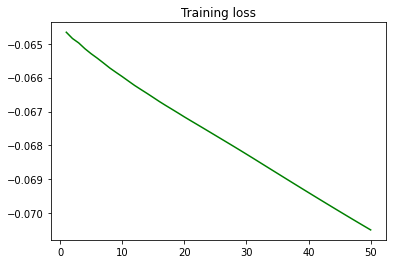

In [46]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', color='green', label='Training loss')
plt.title('Training loss')
plt.show()

In [47]:
pred_weights_1 = opt_model.predict(fit_predict_data).T
pred_weights_1 = pd.DataFrame(pred_weights_1)
pred_weights_1

,0
0,0.127971
1,0.295536
2,0.042587
3,0.232767
4,0.038297
5,0.042354
6,0.026568
7,0.055690
8,0.113858
9,0.024371


## Limiting weights to a threshold

For each asset, weights are limited to a particular value so that risk is distributed among all assets.

In [48]:
def limit_weights(weights_df, threshold):
  return ffn.core.limit_weights(weights_df.to_dict()[0], threshold)

pred_weights_limited = limit_weights(pred_weights_1, 0.35)
pred_weights_limited = pd.DataFrame(pred_weights_limited)
pred_weights_limited

,0
0,0.1280
1,0.2955
2,0.0426
3,0.2328
4,0.0383
5,0.0424
6,0.0266
7,0.0557
8,0.1139
9,0.0244


In [49]:
erDLm1, cvDLm1, srDLm1 = get_port_stats(pct_change, pred_weights_limited, cov)

Expected Returns: 37.96%
Annual Volatility: 27.88%
Sharpe Ratio: 1.36


## Replication of custom sharpe loss function

In [50]:
df.iloc[1:]

,AARTIDRUGS.NS,APLAPOLLO.NS,BSOFT.NS,COFORGE.NS,DHAMPURSUG.NS,ISEC.NS,LINCOLN.NS,SBIN.NS,TATAPOWER.NS,TIRUMALCHM.NS
Date,,,,,,,,,,
2018-04-05,140.774994,211.684998,137.442810,879.849976,136.600006,445.399994,227.000000,259.299988,83.500000,192.725006
2018-04-06,146.225006,210.524994,139.742859,903.500000,137.149994,441.299988,226.550003,259.700012,84.500000,193.789993
2018-04-09,149.087494,212.089996,138.468506,883.450012,136.850006,436.149994,231.600006,260.649994,85.000000,198.755005
2018-04-10,145.524994,216.360001,137.318497,885.849976,141.000000,427.649994,230.300003,263.299988,87.099998,197.994995
2018-04-11,142.199997,213.300003,138.561752,891.000000,135.850006,419.100006,227.199997,257.049988,87.000000,196.794998
...,...,...,...,...,...,...,...,...,...,...
2022-05-23,425.350006,883.799988,378.100006,3853.199951,265.500000,464.250000,284.649994,460.899994,229.800003,245.850006
2022-05-24,418.899994,907.500000,373.700012,3714.050049,252.250000,440.750000,279.250000,462.049988,227.000000,240.699997
2022-05-25,406.549988,878.750000,343.250000,3453.949951,239.649994,428.399994,264.200012,454.100006,220.899994,226.000000


In [51]:
df.iloc[1:] / df.iloc[1]

,AARTIDRUGS.NS,APLAPOLLO.NS,BSOFT.NS,COFORGE.NS,DHAMPURSUG.NS,ISEC.NS,LINCOLN.NS,SBIN.NS,TATAPOWER.NS,TIRUMALCHM.NS
Date,,,,,,,,,,
2018-04-05,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-04-06,1.038714,0.994520,1.016735,1.026880,1.004026,0.990795,0.998018,1.001543,1.011976,1.005526
2018-04-09,1.059048,1.001913,1.007463,1.004092,1.001830,0.979232,1.020264,1.005206,1.017964,1.031288
2018-04-10,1.033742,1.022085,0.999096,1.006819,1.032211,0.960148,1.014537,1.015426,1.043114,1.027345
2018-04-11,1.010123,1.007629,1.008141,1.012673,0.994510,0.940952,1.000881,0.991323,1.041916,1.021118
...,...,...,...,...,...,...,...,...,...,...
2022-05-23,3.021488,4.175071,2.750962,4.379383,1.943631,1.042322,1.253965,1.777478,2.752096,1.275652
2022-05-24,2.975670,4.287030,2.718949,4.221231,1.846632,0.989560,1.230176,1.781913,2.718563,1.248930
2022-05-25,2.887942,4.151215,2.497402,3.925612,1.754392,0.961832,1.163877,1.751253,2.645509,1.172655


In [52]:
# using a sample set of equal weights for all assets in portfolio and replicating the custom loss function
# calculations
pd.DataFrame(np.multiply((df.iloc[1:] / df.iloc[1]).values, np.array([1 / port_len for x in range(port_len)])))

,0,1,2,3,4,5,6,7,8,9
0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1,0.103871,0.099452,0.101673,0.102688,0.100403,0.099079,0.099802,0.100154,0.101198,0.100553
2,0.105905,0.100191,0.100746,0.100409,0.100183,0.097923,0.102026,0.100521,0.101796,0.103129
3,0.103374,0.102208,0.099910,0.100682,0.103221,0.096015,0.101454,0.101543,0.104311,0.102734
4,0.101012,0.100763,0.100814,0.101267,0.099451,0.094095,0.100088,0.099132,0.104192,0.102112
...,...,...,...,...,...,...,...,...,...,...
1019,0.302149,0.417507,0.275096,0.437938,0.194363,0.104232,0.125396,0.177748,0.275210,0.127565
1020,0.297567,0.428703,0.271895,0.422123,0.184663,0.098956,0.123018,0.178191,0.271856,0.124893
1021,0.288794,0.415122,0.249740,0.392561,0.175439,0.096183,0.116388,0.175125,0.264551,0.117266
1022,0.291280,0.407256,0.257343,0.395278,0.179941,0.094264,0.116828,0.180833,0.265210,0.122532


In [53]:
data = tf.divide(tf_port_data, tf_port_data[0])  
data.shape

TensorShape([1024, 10])

# Statistical Models (RiskFolio-Lib)

In [54]:
# Calculating returns
Y = pct_change
Y

,AARTIDRUGS.NS,APLAPOLLO.NS,BSOFT.NS,COFORGE.NS,DHAMPURSUG.NS,ISEC.NS,LINCOLN.NS,SBIN.NS,TATAPOWER.NS,TIRUMALCHM.NS
Date,,,,,,,,,,
2018-04-05,0.035491,0.034806,0.009359,0.015641,0.003674,0.000674,0.005983,0.048524,0.005418,0.019331
2018-04-06,0.038714,-0.005480,0.016735,0.026880,0.004026,-0.009205,-0.001982,0.001543,0.011976,0.005526
2018-04-09,0.019576,0.007434,-0.009119,-0.022191,-0.002187,-0.011670,0.022291,0.003658,0.005917,0.025621
2018-04-10,-0.023895,0.020133,-0.008305,0.002717,0.030325,-0.019489,-0.005613,0.010167,0.024706,-0.003824
2018-04-11,-0.022848,-0.014143,0.009054,0.005814,-0.036525,-0.019993,-0.013461,-0.023737,-0.001148,-0.006061
...,...,...,...,...,...,...,...,...,...,...
2022-05-23,0.012015,-0.037831,-0.014081,0.017494,-0.049920,-0.019225,0.002818,-0.003244,-0.014791,-0.029412
2022-05-24,-0.015164,0.026816,-0.011637,-0.036113,-0.049906,-0.050619,-0.018971,0.002495,-0.012185,-0.020948
2022-05-25,-0.029482,-0.031680,-0.081483,-0.070031,-0.049950,-0.028020,-0.053894,-0.017206,-0.026872,-0.061072


## HRP (Hierarchical Risk Parity)

Reference - https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/

### Naive Risk Parity
Naive risk parity or naïve risk weighting does not use equal weights. Instead, it uses the inverse risk approach. This approach gives lower weight to riskier assets and more significant weight to less risky assets. This method ensures that the risk contribution of each asset is the same.

### Risk measures - CVaR, CDaR, Ulcer Index

Different risk measures interpret risk in different ways.

In [55]:
model='HRP' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
# RISK MEASURE - USED TO OPTIMIZE THE PORTFOLIO USING NAIVE RISK PARITY
# Risk Measure - Conditional Value at Risk
# rm = 'CVaR'
# Risk Measure - Conditional Drawdown at Risk of uncompounded cumulative returns
# rm = 'CDaR'
# Risk Measure - Ulcer Index of uncompounded cumulative returns.
rm = 'UCI' # BEST RISK MEASURE
linkage = 'single' # Linkage method used to build clusters
max_k = port_len # the maximum number of clusters that can be allowed

/usr/local/lib/python3.7/dist-packages/riskfolio/PlotFunctions.py:2237: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


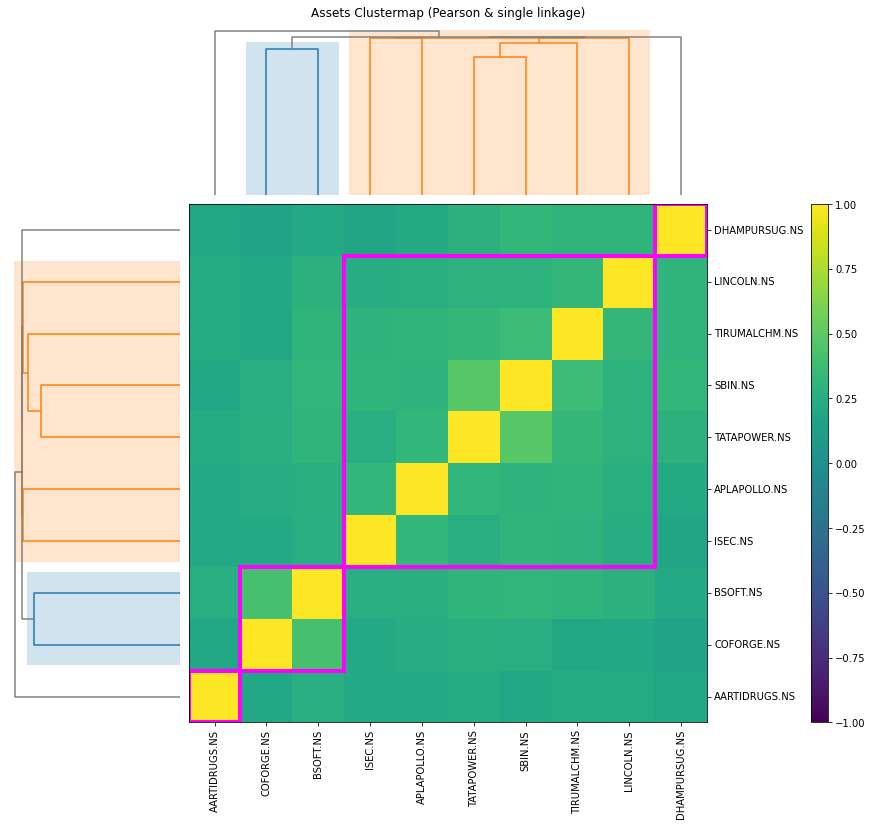

In [56]:
# Plotting Assets Clusters

ax = rp.plot_clusters(returns=Y,
                      codependence=codependence,
                      linkage=linkage,
                      k=None,
                      max_k=max_k,
                      ax=None)

In [57]:
# Building the portfolio object
port1 = rp.HCPortfolio(returns=Y)

In [58]:
# Estimate optimal portfolio:

w1 = port1.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      linkage=linkage,
                      max_k=max_k)

display(w1.T)

,AARTIDRUGS.NS,APLAPOLLO.NS,BSOFT.NS,COFORGE.NS,DHAMPURSUG.NS,ISEC.NS,LINCOLN.NS,SBIN.NS,TATAPOWER.NS,TIRUMALCHM.NS
weights,0.12738,0.063139,0.067795,0.26082,0.082655,0.050381,0.087232,0.111013,0.098651,0.050933


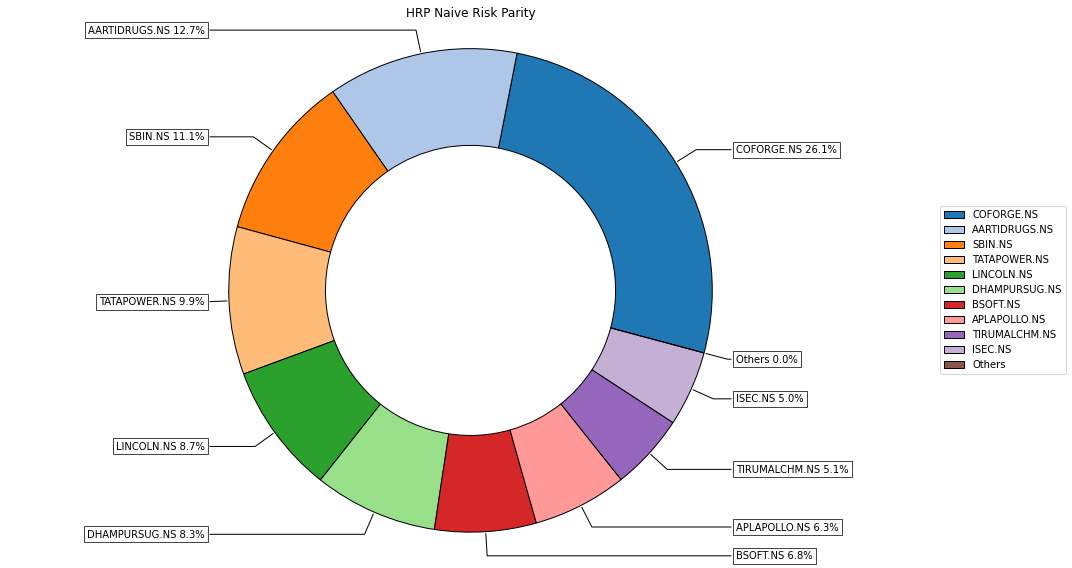

In [59]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w1,
                 title='HRP Naive Risk Parity',
                 others=0,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=15,
                 ax=None)

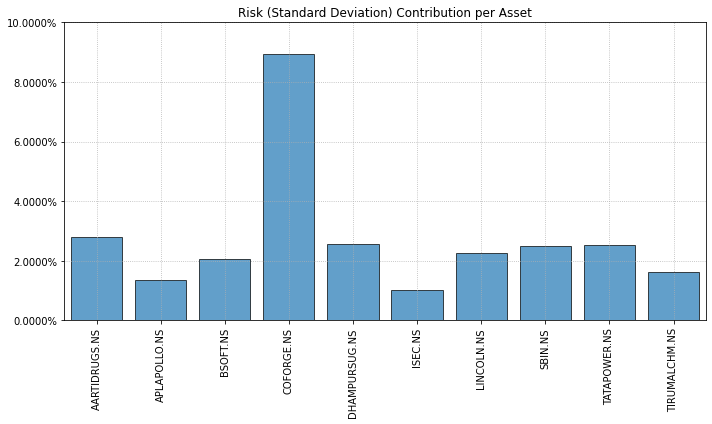

In [60]:
# Plotting the risk contribution graph of each asset

ax = rp.plot_risk_con(w=w1,
                 cov=port1.cov, 
                 returns=port1.returns, 
                 ax=None)

In [61]:
erW1, cvW1, srW1 = get_port_stats(port1.returns, w1, port1.cov)

Expected Returns: 33.62%
Annual Volatility: 27.65%
Sharpe Ratio: 1.22


## HERC (Hierarchical Equal Risk Contribution)

Reference - https://hudsonthames.org/beyond-risk-parity-the-hierarchical-equal-risk-contribution-algorithm/

### Naive Risk Parity
Naive risk parity or naïve risk weighting does not use equal weights. Instead, it uses the inverse risk approach. This approach gives lower weight to riskier assets and more significant weight to less risky assets. This method ensures that the risk contribution of each asset is the same.

### Risk measures - CVaR, CDaR, Ulcer Index

Different risk measures interpret risk in different ways.

In [86]:
model='HERC' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
# RISK MEASURE - USED TO OPTIMIZE THE PORTFOLIO USING NAIVE RISK PARITY
# Risk Measure - Conditional Value at Risk
# rm = 'CVaR'
# Risk Measure - Conditional Drawdown at Risk of uncompounded cumulative returns
rm = 'CDaR' # BEST RISK MEASURE
# Risk Measure - Ulcer Index of uncompounded cumulative returns.
# rm = 'UCI'
linkage = 'complete' # Linkage method used to build clusters
max_k = port_len # Max number of clusters used in two difference gap statistic, only for HERC model

/usr/local/lib/python3.7/dist-packages/riskfolio/PlotFunctions.py:2237: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


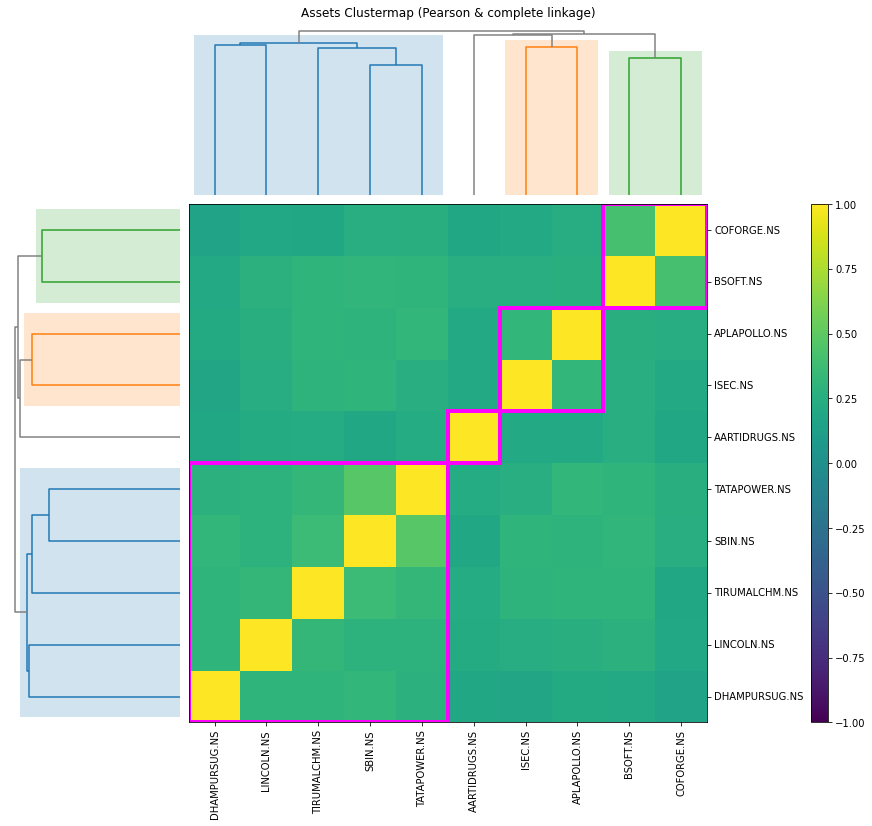

In [87]:
ax = rp.plot_clusters(returns=Y,
                      codependence=codependence,
                      linkage=linkage,
                      k=None,
                      max_k=max_k,
                      ax=None)

In [88]:
# Building the portfolio object
port2 = rp.HCPortfolio(returns=Y)

In [89]:
# Estimate optimal portfolio:

w2 = port2.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      linkage=linkage,
                      max_k=max_k)

display(w2.T)

,AARTIDRUGS.NS,APLAPOLLO.NS,BSOFT.NS,COFORGE.NS,DHAMPURSUG.NS,ISEC.NS,LINCOLN.NS,SBIN.NS,TATAPOWER.NS,TIRUMALCHM.NS
weights,0.026306,0.016615,0.058859,0.127326,0.144807,0.014305,0.178705,0.190592,0.150808,0.091678


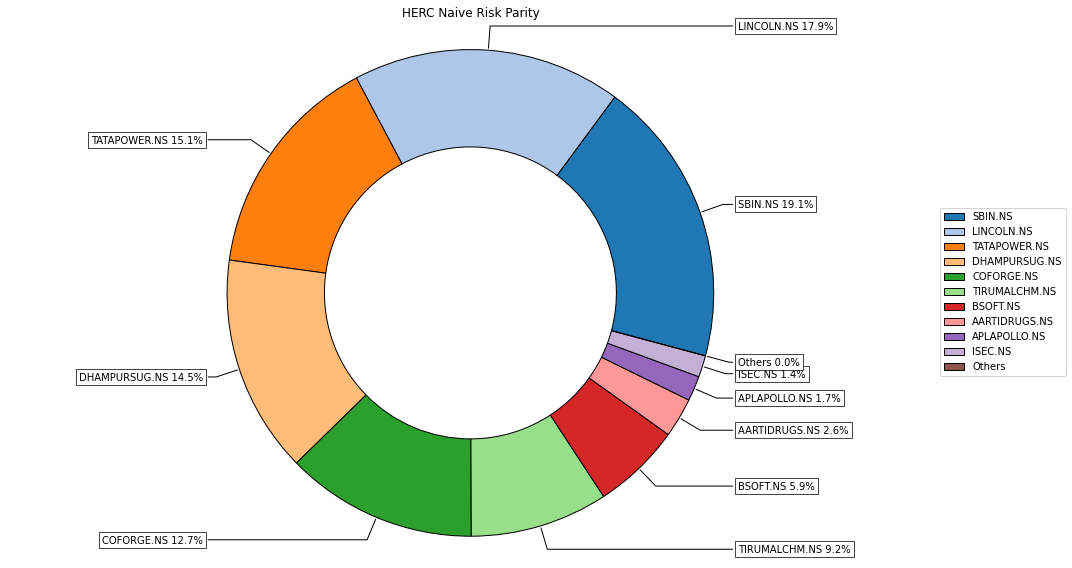

In [90]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w2,
                 title='HERC Naive Risk Parity',
                 others=0,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=15,
                 ax=None)

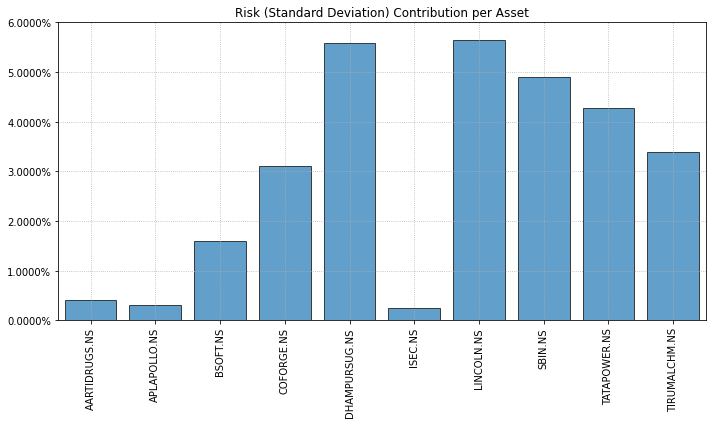

In [91]:
# Plotting the risk contribution graph of each asset

ax = rp.plot_risk_con(w=w2,
                 cov=port2.cov, 
                 returns=port2.returns, 
                 ax=None)

In [92]:
erW2, cvW2, srW2 = get_port_stats(port2.returns, w2, port2.cov)

Expected Returns: 29.01%
Annual Volatility: 29.51%
Sharpe Ratio: 0.98


# Comparsion of HRP, HERC and DL models

In [93]:
comparison_models_len = 3

In [94]:
pred_weights_1_index_changed = pred_weights_limited.reset_index(drop = True)
pred_weights_1_index_changed = pred_weights_1_index_changed.set_index(w1.index)
pred_weights_1_index_changed = pred_weights_1_index_changed.rename({0: 'weights'}, axis=1)

In [95]:
compare_dl_w1_w2 = pd.concat([pred_weights_1_index_changed,
                              w1,
                              w2], 
                             keys=["DL Model Weights",
                                   "HRP Weights (Riskfolio lib)", 
                                   "HERC Weights (Riskfolio lib)"], 
                             axis= 1)

compare_dl_w1_w2

,DL Model Weights,HRP Weights (Riskfolio lib),HERC Weights (Riskfolio lib)
,weights,weights,weights
AARTIDRUGS.NS,0.1280,0.127380,0.026306
APLAPOLLO.NS,0.2955,0.063139,0.016615
BSOFT.NS,0.0426,0.067795,0.058859
COFORGE.NS,0.2328,0.260820,0.127326
DHAMPURSUG.NS,0.0383,0.082655,0.144807
ISEC.NS,0.0424,0.050381,0.014305
LINCOLN.NS,0.0266,0.087232,0.178705
SBIN.NS,0.0557,0.111013,0.190592
TATAPOWER.NS,0.1139,0.098651,0.150808


In [96]:
def get_stats_df(er, cv, sr, col_name):
  stats_df = pd.DataFrame(np.array([er, cv, sr]).T, index=["Expected Returns", "Annual Volatility", "Sharpe Ratio"])
  stats_df = stats_df.rename({ 0: col_name }, axis = 1)
  
  return stats_df

In [97]:
port_stats_dl1_dl2_w1_w2 = pd.concat([get_stats_df(erDLm1, cvDLm1, srDLm1, "DL Model"),
                                 get_stats_df(erW1, cvW1, srW1, "HRP (Riskfolio lib)"),
                                 get_stats_df(erW2, cvW2, srW2, "HERC (Riskfolio lib)")], 
                                axis = 1)

port_stats_dl1_dl2_w1_w2

,DL Model,HRP (Riskfolio lib),HERC (Riskfolio lib)
Expected Returns,37.96,33.62,29.01
Annual Volatility,27.88,27.65,29.51
Sharpe Ratio,1.36,1.22,0.98


## Plotting Risk contribution of each asset for each method

In [98]:
colors = ["blue", "red", "green", "yellow", "pink"]

weights_list = [pred_weights_1_index_changed, w1, w2] 
title_list = ["DL Model Weights",
            "HRP Weights (Riskfolio lib)",
            "HERC Weights (Riskfolio lib)"]

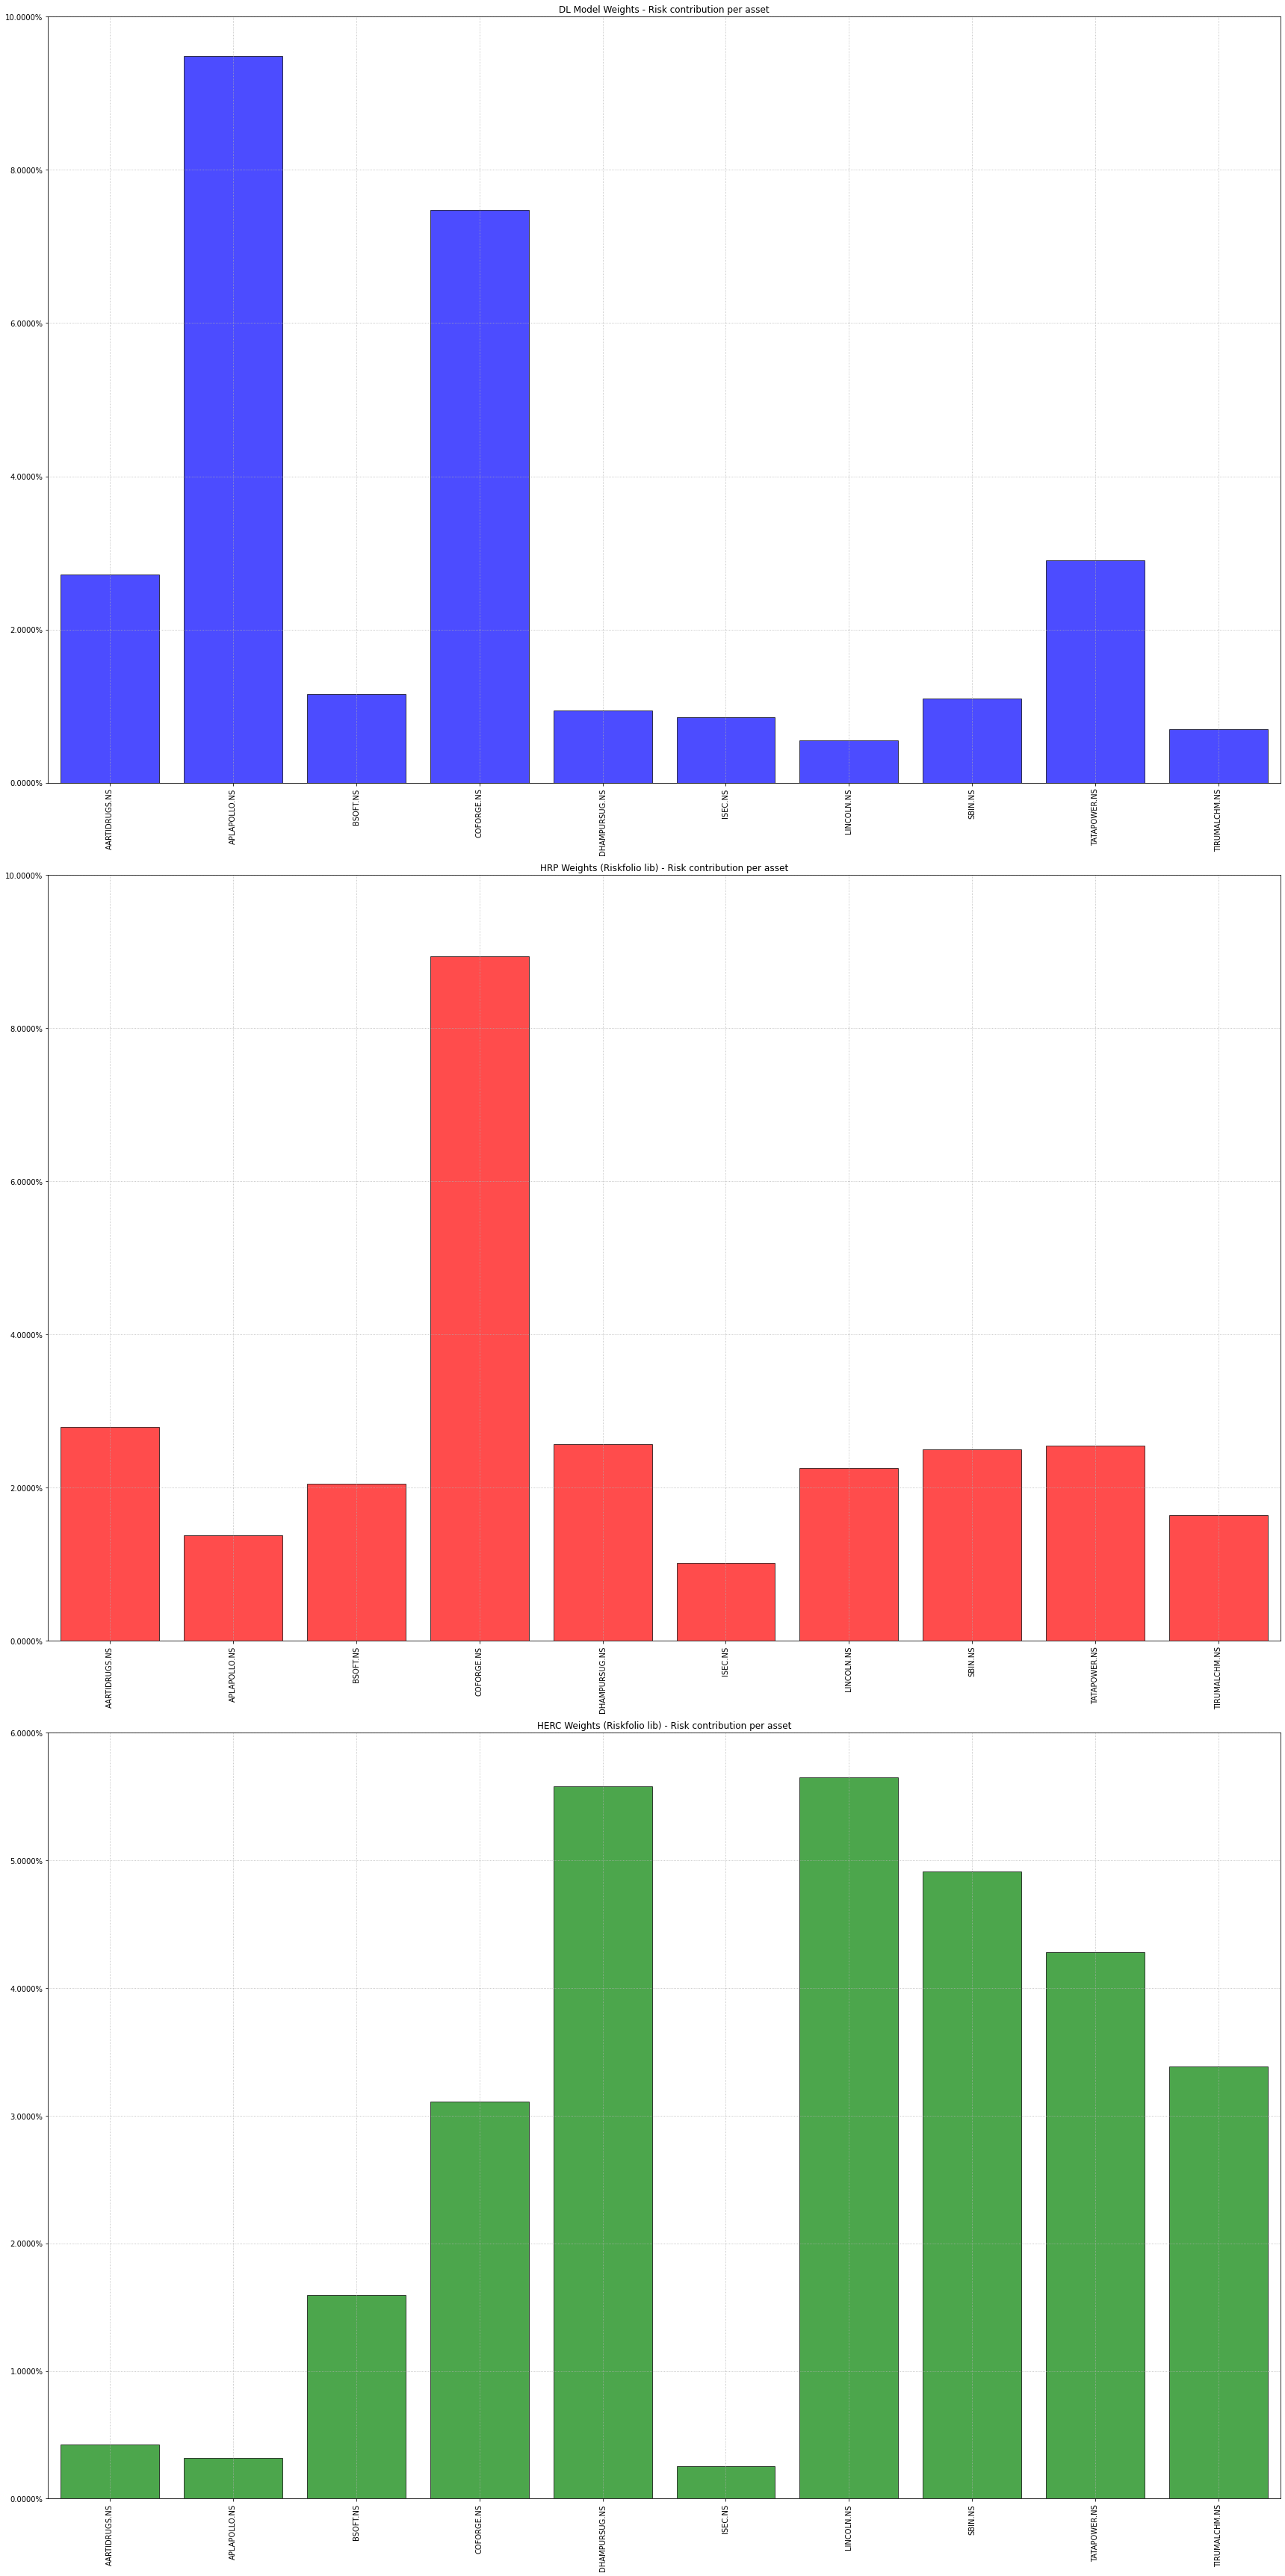

In [99]:
# Plotting the risk contribution graph of each asset for each comparison method

figure, axis = plt.subplots(comparison_models_len, 1, figsize=(24,48), facecolor=(1, 1, 1)) # (rows, cols, figsize, facecolor)

for i in range(comparison_models_len):
  rp.plot_risk_con(w=weights_list[i],
                  cov=cov, 
                  color=colors[i],
                  returns=pct_change,
                  ax = axis[i])
  
  axis[i].set_title(title_list[i] + " - Risk contribution per asset")


# Final output generator

In [100]:
def get_final_score(dl_weights, stat_weight_1, stat_weight_2, fundamentals_analyser_score):
  max_w_alloc_count = math.floor(port_len / 3)
  avg_w_alloc_count = math.floor(port_len / 3)
  min_w_alloc_count = port_len - (max_w_alloc_count + avg_w_alloc_count)

  final_weights_without_softmax_dict = {}

  # Allocating maximum weight from the three models to the most fundamentally strong assets
  for i in range(max_w_alloc_count):

    cur_asset = fundamentals_analyser_score[i][0]
    alloc_weight = max(dl_weights[cur_asset], 
                       stat_weight_1[cur_asset], 
                       stat_weight_2[cur_asset])
    final_weights_without_softmax_dict[cur_asset] = alloc_weight
    
  # Allocating average weight from the three models to assets with average fundamentals
  for i in range(max_w_alloc_count, max_w_alloc_count + avg_w_alloc_count):

    cur_asset = fundamentals_analyser_score[i][0]
    alloc_weight = (dl_weights[cur_asset] +
                    stat_weight_1[cur_asset] + 
                    stat_weight_2[cur_asset]) / 3
    final_weights_without_softmax_dict[cur_asset] = alloc_weight
    
  # Allocating minimum weight from the three models to least fundamentally strong assets
  for i in range(max_w_alloc_count + avg_w_alloc_count, port_len):

    cur_asset = fundamentals_analyser_score[i][0]
    alloc_weight = min(dl_weights[cur_asset], 
                       stat_weight_1[cur_asset], 
                       stat_weight_2[cur_asset])
    final_weights_without_softmax_dict[cur_asset] = alloc_weight 

  sorted_dict = dict(sorted(final_weights_without_softmax_dict.items()))
  weights_only = np.array([sorted_dict[i] for i in sorted_dict])
  extra_value_to_append = 0
  is_sum_greater_than_one = False

  if sum(weights_only) > 1:
    is_sum_greater_than_one = True
    extra_value_to_append = sum(weights_only) - 1
  elif sum(weights_only) < 1:
    extra_value_to_append = 1 - sum(weights_only)

  dict_keys = list(sorted_dict.keys())
  
  final_weights_list = []
  # final_weights_list = softmax(weights_only)
  final_weights_dict = {}
  low_allocation_assets = 1 # this variable is used to make sure weights don't go negative in case the sum is greater than one

  for i in range(port_len):

    if is_sum_greater_than_one:

      if weights_only[i] - (low_allocation_assets * (extra_value_to_append / port_len)) < 0:
        final_weights_list.append(weights_only[i])
        final_weights_dict[dict_keys[i]] = weights_only[i]
        # in case while subraction the asset weight goes below zero, the value to be subtracted is carried to the next asset
        low_allocation_assets += 1
      else:
        final_weights_list.append(weights_only[i] - (low_allocation_assets * (extra_value_to_append / port_len)))
        final_weights_dict[dict_keys[i]] = weights_only[i] - (low_allocation_assets * (extra_value_to_append / port_len))
        low_allocation_assets = 1
    else:
      final_weights_list.append(weights_only[i] + (extra_value_to_append / port_len))
      final_weights_dict[dict_keys[i]] = weights_only[i] + (extra_value_to_append / port_len)

  return final_weights_dict, final_weights_list

In [101]:
final_weights_dict, final_weights = get_final_score(pred_weights_1_index_changed.to_dict()['weights'],
                w1.to_dict()['weights'],
                w2.to_dict()['weights'], 
                sorted_score_dict)

final_weights_dict

{'AARTIDRUGS.NS': 0.04074676024396932,
 'APLAPOLLO.NS': 0.13952509017390255,
 'BSOFT.NS': 0.0822354724695716,
 'COFORGE.NS': 0.27526023199340144,
 'DHAMPURSUG.NS': 0.10302760347144603,
 'ISEC.NS': 0.06482179117172585,
 'LINCOLN.NS': 0.04104036663817769,
 'SBIN.NS': 0.07014036663817769,
 'TATAPOWER.NS': 0.11309166205047887,
 'TIRUMALCHM.NS': 0.07011065514914894}

In [102]:
sum(final_weights)

0.9999999999999999

In [103]:
final_weights_df = pd.DataFrame(final_weights)
final_weights_df = final_weights_df.reset_index(drop = True)
final_weights_df = final_weights_df.set_index(w1.index)
final_weights_df = final_weights_df.rename({0: 'weights'}, axis=1)

final_weights_df

,weights
AARTIDRUGS.NS,0.040747
APLAPOLLO.NS,0.139525
BSOFT.NS,0.082235
COFORGE.NS,0.275260
DHAMPURSUG.NS,0.103028
ISEC.NS,0.064822
LINCOLN.NS,0.041040
SBIN.NS,0.070140
TATAPOWER.NS,0.113092
TIRUMALCHM.NS,0.070111


In [104]:
er, cv, sr = get_port_stats(pct_change, final_weights_df, cov)

Expected Returns: 35.1%
Annual Volatility: 28.62%
Sharpe Ratio: 1.23


<AxesSubplot:title={'center':'Final weights - Composition'}>

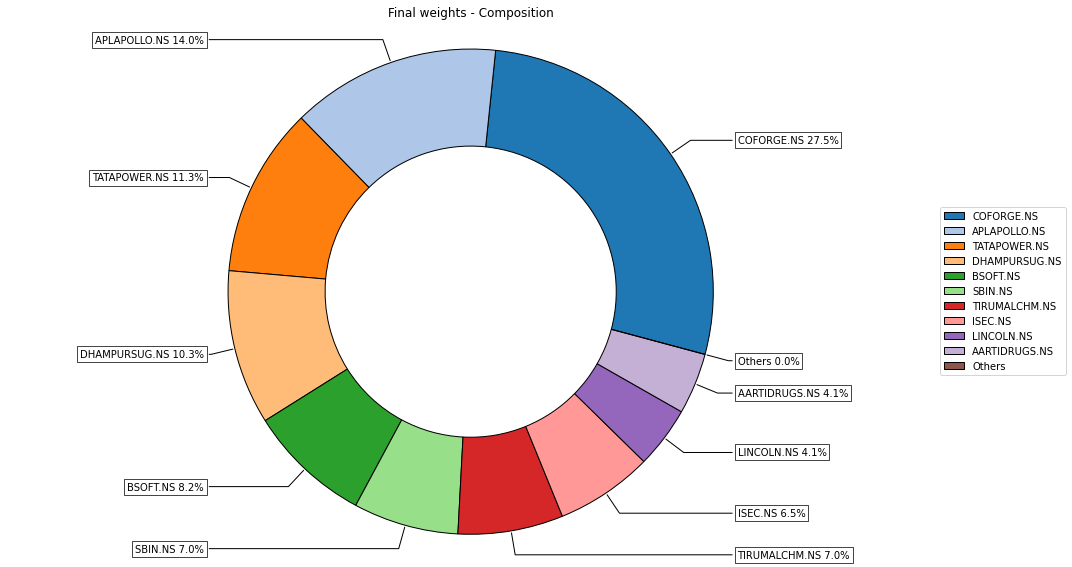

In [110]:
rp.plot_pie(w=final_weights_df,
            title='Final weights - Composition',
            others=0,
            nrow=25,
            cmap="tab20",
            height=8,
            width=15,
            ax=None)

<AxesSubplot:title={'center':'Risk (Standard Deviation) Contribution per Asset'}>

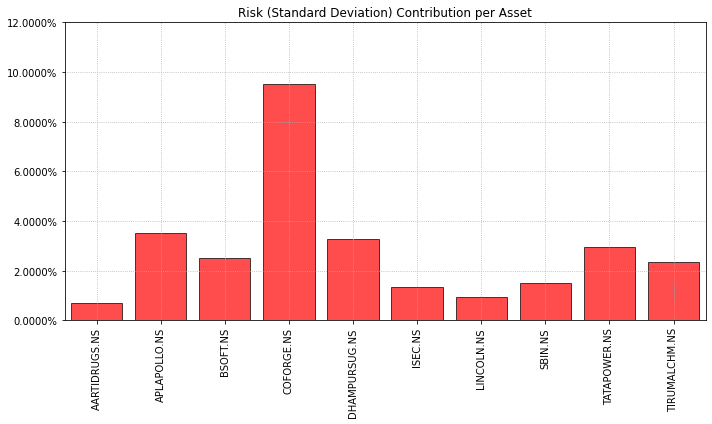

In [105]:
figure, axis = plt.subplots(1, 1, figsize=(24,48), facecolor=(1, 1, 1))

rp.plot_risk_con(w=final_weights_df,
                  cov=cov, 
                  color="red",
                  returns=pct_change,
                  ax = None)

# Finding amount and shares to be allocated to each asset in portfolio based on user budget

In [106]:
def get_allocations(weights, budget, tickers):

  alloc_amt = dict()
  alloc_shares = dict()

  for t in tickers:
    amt_allocated_for_ticker = round(weights.loc[t, "weights"] * budget, 2)
    alloc_amt[t] = amt_allocated_for_ticker
    alloc_shares[t] = int(amt_allocated_for_ticker // extra_info_tickers.tickers[t].info["regularMarketPrice"])

  return alloc_amt, alloc_shares

In [107]:
# getting amount and share allocations of each stock for a budget of 10 lakhs 
amt_allocated, shares_allocated = get_allocations(final_weights_df, 1000000, tickers)

In [108]:
print('Amount allocated for each asset in portfolio')
amt_allocated

Amount allocated for each asset in portfolio


{'AARTIDRUGS.NS': 40746.76,
 'APLAPOLLO.NS': 139525.09,
 'BSOFT.NS': 82235.47,
 'COFORGE.NS': 275260.23,
 'DHAMPURSUG.NS': 103027.6,
 'ISEC.NS': 64821.79,
 'LINCOLN.NS': 41040.37,
 'SBIN.NS': 70140.37,
 'TATAPOWER.NS': 113091.66,
 'TIRUMALCHM.NS': 70110.66}

In [109]:
print('Shares allocated for each asset in portfolio')
shares_allocated

Shares allocated for each asset in portfolio


{'AARTIDRUGS.NS': 98,
 'APLAPOLLO.NS': 160,
 'BSOFT.NS': 226,
 'COFORGE.NS': 74,
 'DHAMPURSUG.NS': 425,
 'ISEC.NS': 151,
 'LINCOLN.NS': 148,
 'SBIN.NS': 149,
 'TATAPOWER.NS': 503,
 'TIRUMALCHM.NS': 294}